In [1]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
# from libs.simulation_tools import *
from libs.satellite import *

In [2]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
year = 2021
day = 357
hour = 16
minute = 29
t = np.arange(0, 241, 10)
second = 53 + t
utc = 9
latitude = location[:, 0]
longitude = location[:, 1]
elevation = location[:, 2]

slant_path_lst = np.zeros(len(second))
zenith_angle_lst = np.zeros(len(second))
for idx in range(len(second)):
    slant_path_lst[idx], zenith_angle_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude[idx], latitude[idx], elevation[idx]
    )

slant_path_lst = slant_path_lst * 1000

In [3]:
tau_zen_lst = np.array([0.91, 0.53])

qber_values = np.zeros((len(tau_zen_lst), len(zenith_angle_lst)))
yield_values = np.zeros((len(tau_zen_lst), len(zenith_angle_lst)))
skr_values = np.zeros((len(tau_zen_lst), len(zenith_angle_lst)))

In [4]:
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_lst)):
        zenith_angle_deg = zenith_angle_lst[jdx]
        zenith_angle_rad = np.radians(zenith_angle_deg)
        
        w_L = slant_path_lst[jdx] * theta_rad

        qber_values[idx][jdx], yield_values[idx][jdx] = compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
            zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )

        Q_1, e_1 = compute_Q_1_e_1(
            sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
            zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )

        skr_values[idx][jdx] = compute_SKR(
            qber_values[idx][jdx], yield_values[idx][jdx], Q_1, e_1
        )

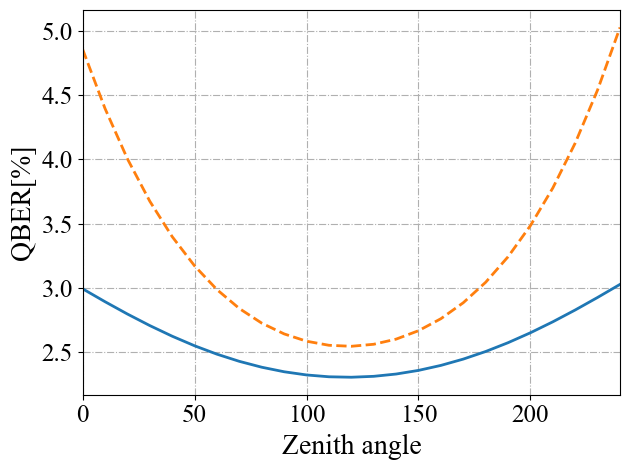

In [5]:
plt.plot(t, qber_values[0][:]*100)
plt.plot(t, qber_values[1][:]*100, ls='--')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"QBER[%]")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
# plt.savefig(f'results/qber_{n_s}.png')
# print(f"✅ Saved as: qber_{n_s}.png")

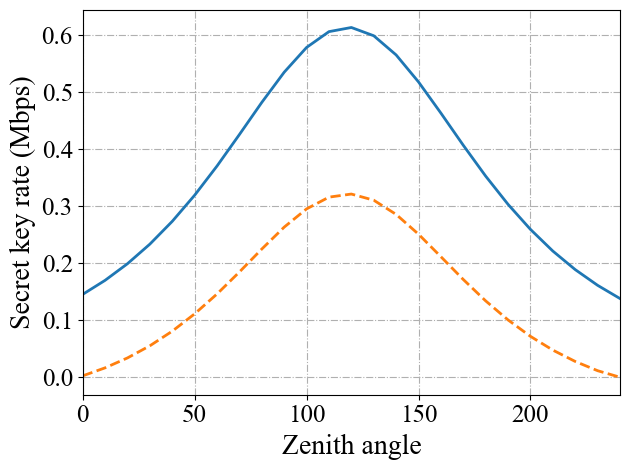

In [6]:
plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')

# plt.plot(zenith_angle_deg_list, yield_values[0][:])
# plt.plot(zenith_angle_deg_list, yield_values[1][:], ls='--')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
# plt.savefig(f'results/skr_{n_s}.png')
# print(f"✅ Saved as: skr_{n_s}.png")

In [7]:
np.save('results/qber_analysis', qber_values)
np.save('results/skr_analysis', skr_values)